In [1]:
import parallelPermutationTest as ppt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plots import timePlotSNSMC
import time
from scipy.stats import ttest_ind


In [2]:
%load_ext cython
%load_ext rpy2.ipython

In [3]:
%%capture
%%R

install.packages("coin")


install.packages("perm")

install.packages("exactRankTests")


library(coin)

In [4]:
%%R
    runMcCoin <- function(x,y,batches,output,n_samples) {
       e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
            
            DV <- c(x[[i]], y[[i]])
            IV <- factor(rep(c("A", "B"), c(length(x[[i]]), length(y[[i]]))))

            output[[i]] <- pvalue(oneway_test(DV ~ IV, distribution=approximate(batches)))      
            
            }
    

    return(output)
        
    }

In [5]:
def McCoin(A,B, batches):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i batches
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runMcCoin(x,y, batches, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)



In [6]:
%%R
    runShift <- function(x,y,output,n_samples) {
       e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
            
            DV <- c(x[[i]], y[[i]])
            IV <- factor(rep(c("A", "B"), c(length(x[[i]]), length(y[[i]]))))

            output[[i]] <- pvalue(oneway_test(DV ~ IV, distribution=exact(c("shift"))))      
            
            }
    

    return(output)
        
    }

In [7]:
def shift(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runShift(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [8]:
def timeit(f, a, b, s=None):
    start = time.time()
    if s:
        f(a, b, s)
    else:
        f(a, b)
    end = time.time()
    return end - start

def run_experiment(samples, MC_samples, n_range):
    A_data = lambda n,n_samples : np.array([np.random.randint(0,n,n,dtype=np.int32) for _ in range(n_samples)])
    B_data = lambda n,n_samples : np.array([np.random.randint(0,n ,n,dtype=np.int32) for _ in range(n_samples)])
    
    all_plot_data = dict()
            
    for n in n_range:
        
        plot_data = dict()
        plot_data["MC"] = list()
        
        A = A_data(n, samples)
        B = B_data(n, samples)
        
        for mc_samp in MC_samples:
            
            time_MC= list()
            
            for a,b in zip(A, B):
                time_MC.append(timeit(McCoin, a[np.newaxis,:], b[np.newaxis,:], mc_samp))
                
            plot_data["MC"].append(time_MC)
            
        time_green = list()
        for a,b in zip(A, B):
            time_green.append(timeit(ppt.GreenIntCuda, a[np.newaxis,:], b[np.newaxis,:]))
            
        plot_data["Green time"] = time_green
        
        all_plot_data[str(n)] = plot_data
    
    return all_plot_data

In [9]:
mc_ranges = [10**1, 5*10**1, 10**2, 5*10**2,
            10**3, 5*10**3, 10**4, 5*10**4,
            10**5, 5*10**5, 10**6, 5*10**6, 10**7]
mc_samples = len(mc_ranges)
n_samples =5
n_range = [200,300,400]

In [10]:
X = run_experiment(n_samples, mc_ranges, n_range)

In [11]:
names = [r"Monte Carlo – $n=m=200$", r"Monte Carlo – $n=m=300$", r"Monte Carlo – $n=m=400$", 
         r"Green Cuda – $n=m=200$", r"Green Cuda – $n=m=300$", r"Green Cuda – $n=m=400$"]
colors = ["r", "g", "b","r", "g", "b"]

In [12]:
palette = dict(zip(names, colors))

In [13]:
flatten = lambda l, L: [sublist[i] for i in range(L) for sublist in l]

In [14]:
timeList =[flatten(X["200"]["MC"], n_samples), flatten(X["300"]["MC"],n_samples), flatten(X["400"]["MC"],n_samples), 
           X["200"]['Green time']*mc_samples, X["300"]['Green time']*mc_samples, X["400"]['Green time']*mc_samples]

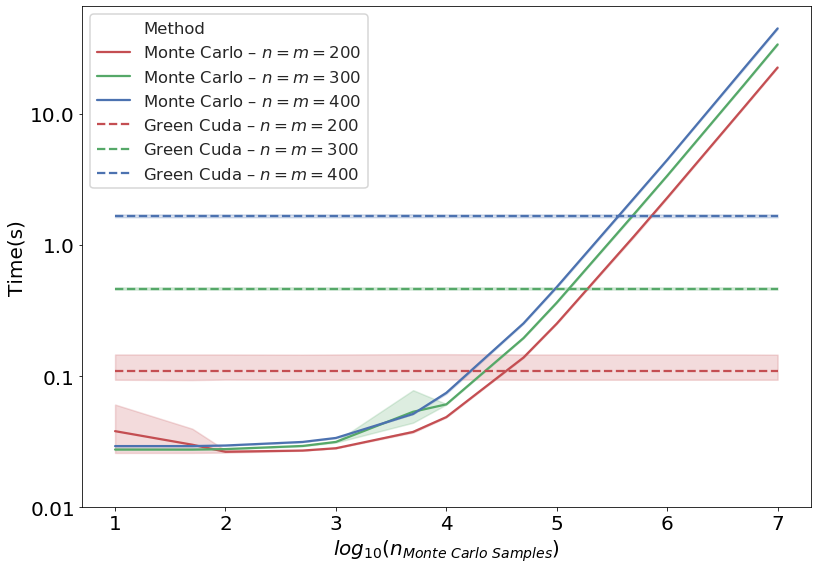

In [15]:
timePlotSNSMC(timeList, [r"Monte Carlo – $n=m=200$", r"Monte Carlo – $n=m=300$", r"Monte Carlo – $n=m=400$",
                       r"Green Cuda – $n=m=200$", r"Green Cuda – $n=m=300$", r"Green Cuda – $n=m=400$"], 
            np.log10(mc_ranges * 5), "Time(s)", r'$log_{10}(n_{Monte\ Carlo\ Samples})$', palette, log=True, path="./figures/experiment8/MCvsParallelGreen")